## Objetivo

Prever se um cliente vai se inscrever à um produto

## 1) Importações

In [3]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import researchpy as rp
import pingouin as pg
from scipy.stats import mannwhitneyu, boxcox
import statsmodels.api as sm
from tqdm.notebook import tqdm
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from pycaret import classification
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [2]:
df = pd.read_csv('data/campaigns.csv')

## 2) Utils

Funções Utilizadas

In [4]:
def decision_tree_summary(df, x, y='y', dt=DecisionTreeClassifier()):
    '''
    Apply decision tree and plot the most important features and tree diagram
    '''
    x, y = df[x], df[y]
    dt.fit(x, y)
    
    # prepare grid for plotting
    plt.figure(figsize=(16, 6))
    gridsize = (1, 5)
    ax1 = plt.subplot2grid(gridsize, (0, 0))
    ax2 = plt.subplot2grid(gridsize, (0, 1), colspan=4)
    
    pd.Series(dt.feature_importances_, index=x.columns).sort_values().plot(kind='barh', ax=ax1) # feature importances
    plot_tree(dt, max_depth=2, feature_names=x.columns, fontsize=10, filled=True,  ax=ax2) # tree visualization
    plt.show()
    
def logistic_regression_summary(df, xcols, y='y'):
    '''
    Apply logistic regression and print summary 
    '''
    y = df[y]
    x = sm.add_constant(df[xcols])
    lr = GLM(y, x, family=sm.families.Binomial()).fit()
    print(lr.summary())
    
def plot_logistic_regression(df, x, y='y', lr=LogisticRegression()):
    
    plt.figure(figsize=(10, 4))
    plt.title(f'Logistic Regression with {x}')
    
    x, y = df[[x]], df[y]
    lr.fit(x, y)
    y_proba = lr.predict_proba(x)[:,1]
    
    plt.plot(x, y, '.', alpha = 0.1)
    plt.plot(x, y_proba, '.', alpha = 0.5)
    plt.show()
    
def drop_cols(df, cols):
    '''
    Drop selected columns
    Returns: dataset without selected columns
    '''
    return df.drop(cols, axis=1)

In [5]:
def categorical_summary(df):
    '''
    Realiza a contagem e percentagem de cada variável categórica
    '''
    df = df.select_dtypes(include='O') # select only categorical features
    for col in df.columns:
        # prepare table with counting and percentage
        df_summary = rp.summary_cat(df[col]).iloc[:,1:] 
        df_summary = df_summary.set_index('Outcome')
        
        # plot table
        plt.title(col)
        sns.heatmap(df_summary, annot=True, cmap='inferno', cbar=False, fmt='g')
        plt.show()
        print('='*60)

def plot_distributions(df, col, target='y', figsize=(10, 3)):
    '''
    Plot histogram and kde of feature for each target
    '''
    plt.figure(figsize=figsize)
    sns.distplot(df[df[target]==True][col], label=True) # plot target true 
    sns.distplot(df[df[target]==False][col], label=False) # plot target false
    plt.legend(loc=1)
    plt.show()
    
def diagnostic_plots(df, col, bins=40, figsize=(10, 4)):
    '''
    function to plot a histogram and a Q-Q plot
    side by side, for a certain variable
    '''        
    print(pg.normality(df[col])) # assess normality
    
    f, ax = plt.subplots(1, 2, figsize=figsize)
    ax[0].set_title(col)
    df[col].hist(bins=bins, grid=False, ax=ax[0]) # plot histogram
    
    pg.qqplot(df[col], dist='norm', ax=ax[1]) # plot qqplot
    plt.show()
    
def difference_summary(df, col, target='y', alpha=0.01):
    '''
    Analyze whether two non-gaussian distributions differ from each other
    More at: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
    '''    
    df_t = df[df[target]==True][col] # select true target
    df_f = df[df[target]==False][col] # select false target
    stat, p = mannwhitneyu(df_t, df_f) # implements mann whitney test
    print('Mann-Whitney U Test')
    print(f'Statistics: {stat} | p-value: {p}')
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

In [6]:
def missing_flag(df, col, null_value=False):
    '''
    Add missing flag for a given column
    Return missing flag in the same column or in another columns depending whether null_value is filled
    '''    
    if null_value:
        df[col] = df[col].fillna(null_value) # create missing flag in the same column
    else:        
        df[col+'_null'] = np.where(df[col].isnull(), 1, 0) # create missing flag in a new column
    return df

def chisquare(df, index, col='y', figsize=(10, 4), annot=True, prop=None):
    '''
    plot contingency table and chi-square statistics for two categorical variables
    '''
    title = 'Frequency table'
    
    if prop:
        cmap='inferno'
        title = 'Percentage table by ' + prop
    else:
        cmap='viridis'
    
    table, results = rp.crosstab(df[index], df[col], test='chi-square', prop=prop) # implement chi-square and cramer's v test
    
    # plot frequency table
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.heatmap(table.iloc[:-1,:-1], cmap=cmap, annot=annot, fmt='.6g', cbar=False)
    plt.show()
    print(results)
    
    # translate cramer's value results
    cramer = results.iloc[-1, -1]
    if cramer > 0.25:
        print('Dependency of variables is very strong')
    elif cramer > 0.15:        
        print('Dependency of variables is strong')
    elif cramer > 0.1:        
        print('Dependency of variables is moderate')
    elif cramer > 0.05:        
        print('Dependency of variables is weak')
    else:
        print('Dependency of variables very weak')

In [7]:
def top_values(df, col, top=3, other='other'):
    '''
    Select top k values and rename remaining 
    Returns: dataset with the values transformed
    '''    
    top_values = df[col].value_counts().head(top).index
    df[col] = df[col].where(df[col].isin(top_values), other=other)
    return df

def cramersv_agg(df, col, target='y', max_values=None, min_values=None):
    df_results = pd.DataFrame(index=['Pearson Chi-square', 'p-value', 'Cramer"s V'])
    if not max_values:
        max_values = df[col].nunique()
    if not min_values:
        min_values = 1
    
    for i in tqdm(range(max_values, min_values, -1)):
        df_copy = deepcopy(df[[col, target]])
        df_copy = top_values(df_copy, col, top=i)
        _, results = rp.crosstab(df_copy[col], df_copy[target], test='chi-square')
        df_results[i] = results.iloc[:, -1].tolist()
        
    fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    df_results.iloc[1, :].plot(kind='bar', title='p_values', ax=ax[0])
    
    df_results.iloc[-1, :].plot(kind='bar', title="cramer's v", ax=ax[1])
    ax[1].hlines(0.25, 0, df_results.shape[1], colors='g', label='very_strong')
    ax[1].hlines(0.15, 0, df_results.shape[1], colors='c', label='strong')
    ax[1].hlines(0.10, 0, df_results.shape[1], colors='y', label='moderate')
    ax[1].hlines(0.05, 0, df_results.shape[1], colors='r', label='weak')
    ax[1].legend(loc=1)
    plt.show() 

In [8]:
def transform_distribution(df, col):
    '''
    Apply log and (1/log_max) for the column selected
    Returns: dataset with the transformations
    '''
    df_trans = df[[col]].dropna() # drop null values
    log_max = np.log(df_trans[col].max())
    
    # analyzing minimum value for shifting the distribution
    min_value = df_trans[col].min()
    print(f'Min value: {min_value}')
    min_value = abs(min_value) + 1
    
    df_trans[col + '_log'] = df_trans[col].apply(lambda x: np.log(x+min_value)) # apply log transformation
    df_trans[col + '_frac'] = df_trans[col].apply(lambda x: 1/(x+min_value)) # apply fraction transformation
    df_trans[col + '_sqrt'] = df_trans[col].apply(lambda x: np.sqrt(x)) # apply square root transformation
    df_trans[col + '_frac_logmax'] = df_trans[col].apply(lambda x: x**(1/log_max)) # apply fraction with max log transformation
    df_trans[col + '_boxcox'], param = boxcox(df_trans[col]+min_value) # apply boxcox transformation
    
    df_trans = df_trans.drop(col, axis=1)
        
    return df.join(df_trans)

def plot_distribution_transform(df, col):
    '''
    Plot diagnostic plots for each transformation
    '''
    cols = [i for i in df.columns if col in i] # select column with similar names
    for col in cols:
        try:
            diagnostic_plots(df, col) # plot histogram and qqplot
        except:
            print('Not possible plotting {col}')
        print('='*80)

In [9]:
def dummy_feature(df, col):
    '''
    Create dummy of the selected feature
    '''
    
    df[col] = pd.get_dummies(df[col], drop_first=True, prefix=col)
    return df

In [10]:
def plot_pivot_table(df, index, columns, values='y', aggfunc='count', annot=True,
                     cmap='inferno', figsize=(10, 8)):
    '''
    Plot pivot table between two features
    '''
    title = 'Pivot table with aggregation function: ' + aggfunc
    df_pivot = pd.pivot_table(df, values, index, columns, aggfunc, fill_value=0) # create pivot table
    
    # plot pivot table
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.heatmap(df_pivot, cmap=cmap, cbar=False, annot=annot, fmt='g')
    plt.show()
    
def feature_flag(df, col, value_false):
    '''
    Create flag column based on 'col'
    '''    
    df[col + '_flag'] = np.where(df[col] == value_false, False, True)
    return df

In [ ]:
def count_target(target):
    '''
    Print number of target and percentage for each class
    '''
    dict_target = target.value_counts().to_dict() # dictionary of countings for each class
    dict_target_perc = target.value_counts(True).round(2).to_dict() # dictionary of percentage of each class
    return dict_target, dict_target_perc

def sampling(df, target='y', sampler=sampler):
    '''
    Perform sampling by the target
    Return sample of original dataset
    '''
    x, y = drop_cols(df, target), df[target]
    
    print('Before sampling')    
    dict_target, dict_target_perc = count_target(y)
        
    print('Values for each target: ', dict_target)
    print('Percentage of each target: ', dict_target_perc, '\n')
    print('='*60)

    x_smp, y_smp = sampler.fit_resample(x, y) # apply sampling
    
    print('\nAfter sampling')   
    dict_target, dict_target_perc = count_target(y_smp)
    print('Values for each target: ', dict_target)
    print('Percentage of each target: ', dict_target_perc)
    
    df_smp = pd.concat([x_smp, y_smp], axis=1)
    
    return df_smp

In [ ]:
def plot_3d_scatterplot(df, x, y, z, c, figsize=(10, 8)):
    '''
    Plot 3D scatter plot of selected features for each target    
    '''
    fig = plt.figure(figsize=figsize)
    ax = Axes3D(fig)

    scatter = ax.scatter(df[x], df[y], df[z], c=df[c]) # create 3d scatter plot
    xlabel, ylabel, zlabel = x, y, z # set labels
    ax.set_title(f'3D scatter plot of {xlabel} x {ylabel} x {zlabel}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    legend = ax.legend(*scatter.legend_elements(), title=c)
    ax.add_artist(legend)

    plt.show()

In [ ]:
def train_test(df, target='y'):
    '''
    Split dataframe into train and test
    '''
    x, y = drop_cols(df, target), df[target]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
                                                        stratify=y, random_state=42)                          
    return x_train, x_test, y_train, y_test

## 3) Análise de dados exploratória

### 1) General analysis

In [11]:
df = drop_cols(df, 'Unnamed: 0') # deleting useless column

Aparentemente o dataset não contém nulos

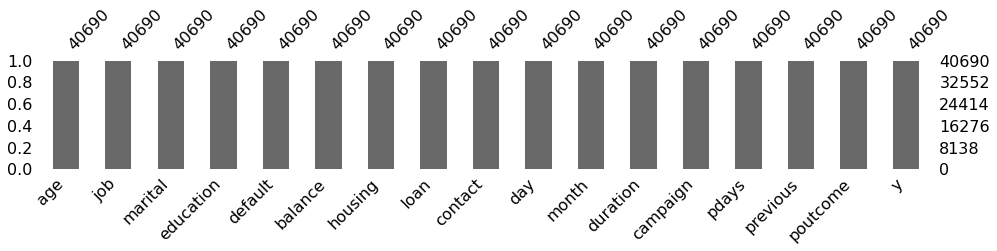

In [12]:
msno.bar(df, figsize=(16, 2));

Mas observando os dados, percebemos que os nulos foram marcados como `unknown`, logo substitui esses valores por `NaN`

Valores nulos serão tratados mais tarde

In [13]:
df.replace('unknown', np.nan, inplace=True)

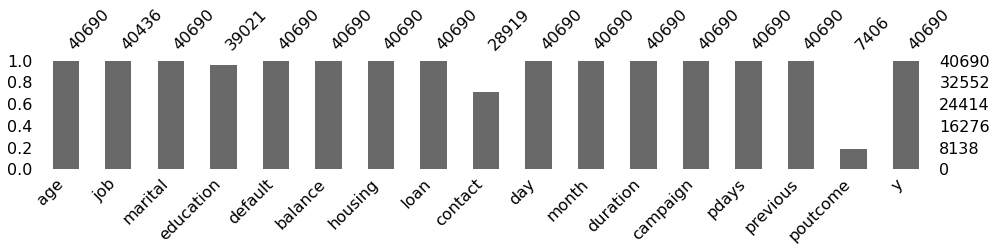

In [14]:
msno.bar(df, figsize=(16, 2));

Existem colunas com valores binários e que converterei para flags binárias

In [15]:
cols = df.nunique()
cols = cols[cols == 2].index.tolist()
cols.remove('contact')

print(f'Binary features: {cols}')

Binary features: ['default', 'housing', 'loan', 'y']


In [16]:
for col in cols:
    df[col] = np.where(df[col] == 'yes', True, False)

#### Numerical Values

Analisando as variáveis numéricas, percebemos que existe assimetria nas variáveis `balance`, `campaign`, `duration`, `pdays` e `previous`

A idade das pessoas não aparenta conter outliers, mas não podemos afirmar o mesmo das demais variáveis. Não eliminarei possíveis outliers; se tivesse contato com a área de negócio, buscaria entender os valores discrepantes das demais variáveis

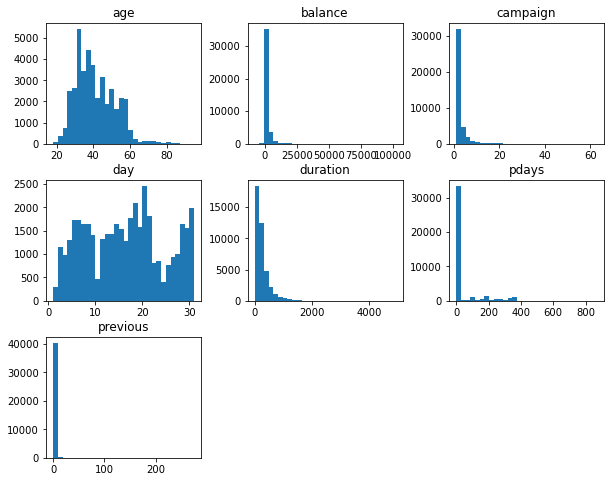

In [17]:
df.select_dtypes(include='int64').hist(bins=30, figsize=(10, 8), grid=False);

#### Categorical values

- `job`: percebemos que a base é composta majoritariamente de clientes de altos cargos como blue-collar e management
- `marital`: maioria das pessoas da base são casadas
- `education`: mais da metade das pessoas tem ensino secundário
- `contact`: maioria das pessoas tem tipo de comunicação celular
- `month`: os meses que mais aparece são no intervalo de maio à agosto
- `poutcome`: mais da metade do resultado da última campanha foi fracassada

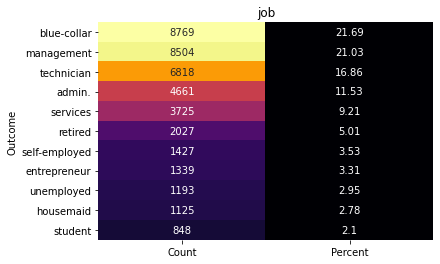

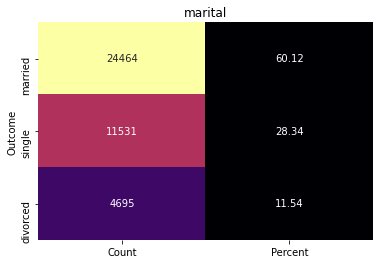

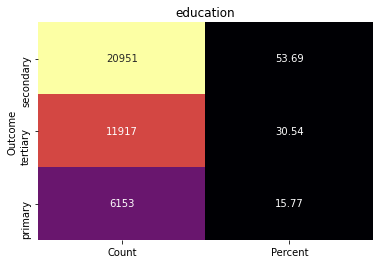

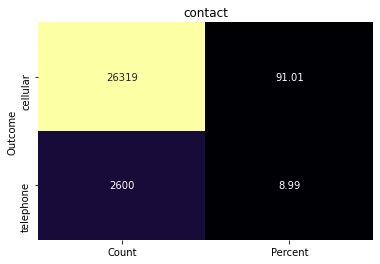

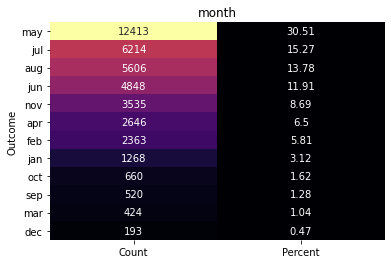

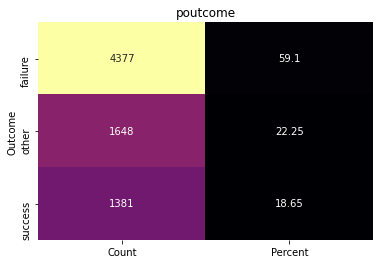

In [18]:
categorical_summary(df)

#### Correlation

Visto  que nem todas variáveis seguem correlação linear, analisei as correlações entre variáveis númericas pela correlação monotônica de spearman

Podemos observar que `pdays` e `previous` são bem parecidas; olharei elas com mais profundidade em breve

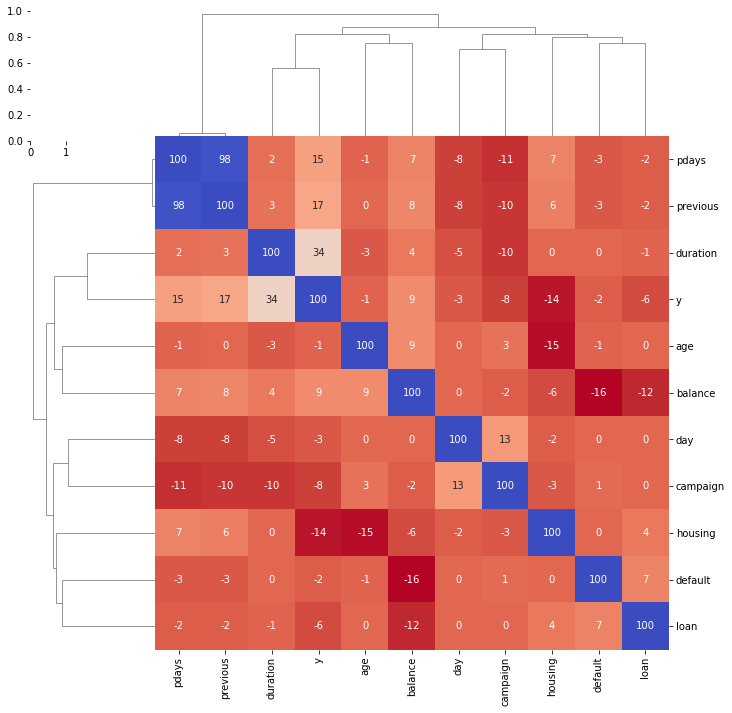

In [19]:
sns.clustermap((df.corr('spearman')*100).astype(int), fmt='g', cbar=False, annot=True, cmap='coolwarm_r');

#### Target

As targets são desbalanceadas, significando que poucas pessoas se inscreveram para o produto

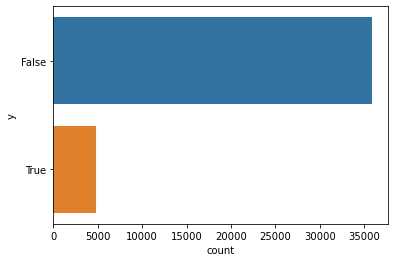

In [20]:
sns.countplot(data=df, y='y');

Em seguida, examinarei as variáveis da base para averiguar seu ganho em discriminar a target e realizar transformações quando necessário 

### 2) age

Plotando a idade para cada target, aparentemente pessoas mais novas tendem a se inscreverem

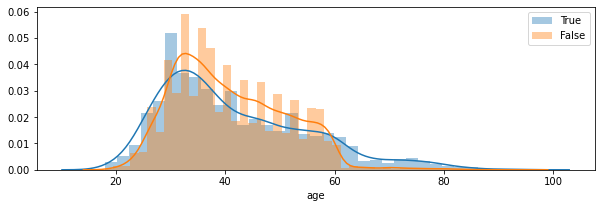

In [21]:
plot_distributions(df, 'age')

Analisando pelo qqplot e teste de Shapiro-Wilk, vericamos que `age` não tem distribuição normal

C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


            W  pval  normal
age  0.960834   0.0   False


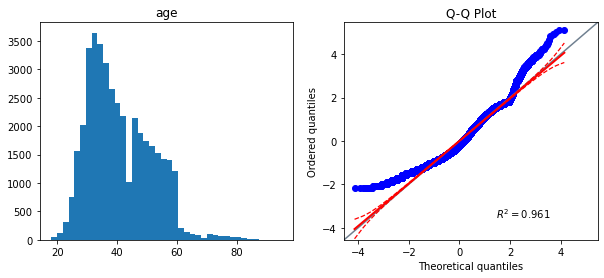

In [22]:
diagnostic_plots(df, 'age')

Dessa forma, pelo teste não-paramétrico de de Mann-Whitney confirmamos que as idades têm distribuições diferentes, então `age` aparenta auxiliar na discriminação da target

In [23]:
difference_summary(df, 'age', alpha=0.05)

Mann-Whitney U Test
Statistics: 84394580.0 | p-value: 0.021834605421601507
Different distribution (reject H0)


### 3) job

Analisando o p-valor do teste do chi-quadrado, podemos rejeitar a hipótese nula de independência e podemos concluir que existe uma dependência entre `job` e `y`, sendo que pelo V de Cramer, esse relacionamento é de `0,13`, considerado moderado

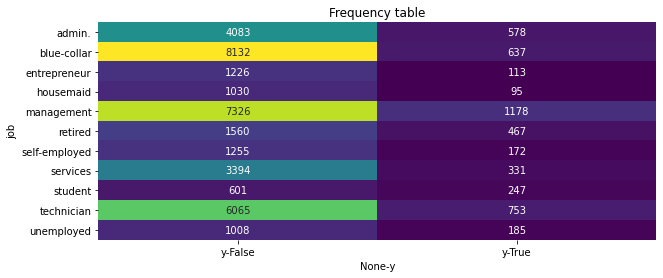

                 Chi-square test   results
0  Pearson Chi-square ( 10.0) =   778.8235
1                     p-value =     0.0000
2                  Cramer's V =     0.1388
Dependency of variables is moderate


In [24]:
chisquare(df, 'job')

Avaliando somente a presença ou não de nulos em `job`, vemos que não tem um relacionamento significativo

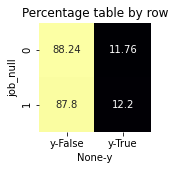

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    0.0477
1                    p-value =    0.8271
2               Cramer's phi =    0.0011
Dependency of variables very weak


In [25]:
chisquare(missing_flag(df, 'job'), 'job_null', figsize=(2, 2), prop='row')

Tratarei os valores faltantes, adicionando valor `other`

In [26]:
df = missing_flag(df, 'job', null_value='other')

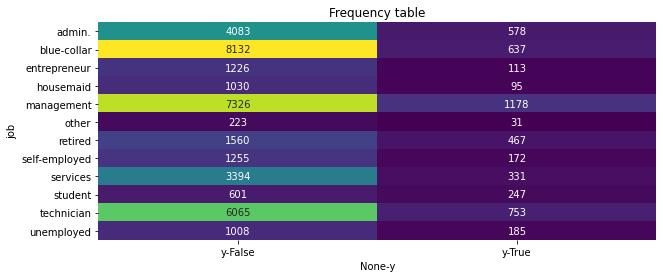

                 Chi-square test   results
0  Pearson Chi-square ( 11.0) =   778.7125
1                     p-value =     0.0000
2                  Cramer's V =     0.1383
Dependency of variables is moderate


In [27]:
chisquare(df, 'job')

In [28]:
df = drop_cols(df, 'job_null')

### 4) marital and education

O estado civil tem uma relação fraca com a target, sendo que 15% dos solteiros se inscreveram

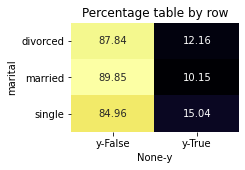

                Chi-square test   results
0  Pearson Chi-square ( 2.0) =   181.5007
1                    p-value =     0.0000
2                 Cramer's V =     0.0668
Dependency of variables is weak


In [29]:
chisquare(df, 'marital', figsize=(3, 2), prop='row')

Quanto maior o grau de educação, maior a chance do usuário se inscrever

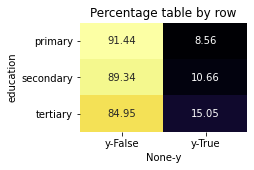

                Chi-square test   results
0  Pearson Chi-square ( 2.0) =   210.5093
1                    p-value =     0.0000
2                 Cramer's V =     0.0734
Dependency of variables is weak


In [30]:
chisquare(df, 'education', figsize=(3, 2), prop='row')

Por ser uma variável categórica ordinal, atribuirei números às variáveis e tratarei o valor nulo como `-1`

In [31]:
map_education = {'primary': 1, 'secondary': 2, 'tertiary': 3}
df['education'] = df['education'].map(map_education).fillna(-1)

### 5) default, housing and loan

- `default`: usuários com crédito em atraso tendem a não se inscreverem
- `housing`: usuários que tem empréstimo de habitação tendem a não se inscreverem
- `loan`: usuários que tem empréstimo pessoal tendem a não se inscreverem

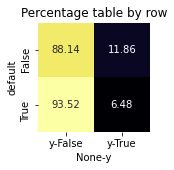

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =   19.8377
1                    p-value =    0.0000
2               Cramer's phi =    0.0221
Dependency of variables very weak


In [32]:
chisquare(df, 'default', figsize=(2, 2), prop='row')

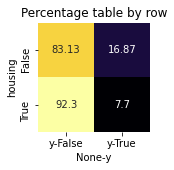

                Chi-square test   results
0  Pearson Chi-square ( 1.0) =   812.0129
1                    p-value =     0.0000
2               Cramer's phi =     0.1413
Dependency of variables is moderate


In [33]:
chisquare(df, 'housing', figsize=(2, 2), prop='row')

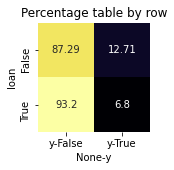

                Chi-square test   results
0  Pearson Chi-square ( 1.0) =   183.9781
1                    p-value =     0.0000
2               Cramer's phi =     0.0672
Dependency of variables is weak


In [34]:
chisquare(df, 'loan', figsize=(2, 2), prop='row')

### 6) balance

O balanço anual médio parece estar bem concentrado. Realizar algumas transformações pode ser útil para ajudar a discriminar a target

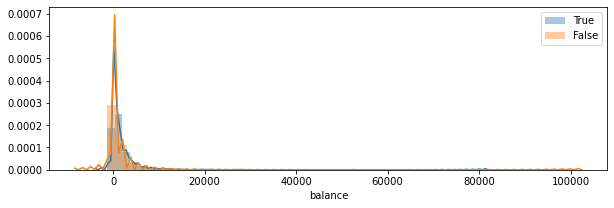

In [35]:
plot_distributions(df, 'balance')

Antes disso, verificando pelo teste de Mann-Whitney, os balanços de cada target são de distribuições diferentes

In [36]:
difference_summary(df, 'balance')

Mann-Whitney U Test
Statistics: 70633494.0 | p-value: 1.0761800003661852e-89
Different distribution (reject H0)


In [37]:
df = transform_distribution(df, 'balance')

Min value: -8019


Nenhuma transformação conseguiu normalizar a distribuição

C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


                W  pval  normal
balance  0.457346   0.0   False


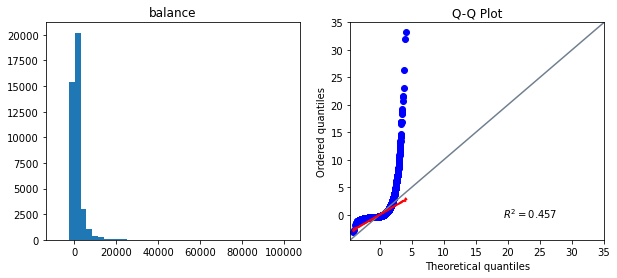

                    W  pval  normal
balance_log  0.670747   0.0   False


C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


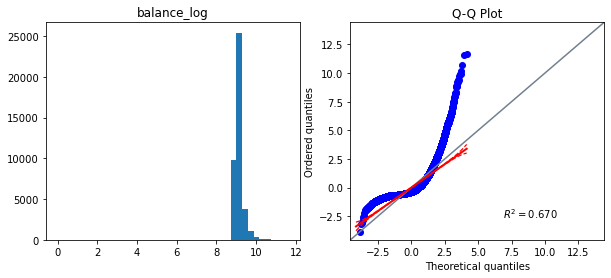

                     W  pval  normal
balance_frac  0.000628   0.0   False


C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


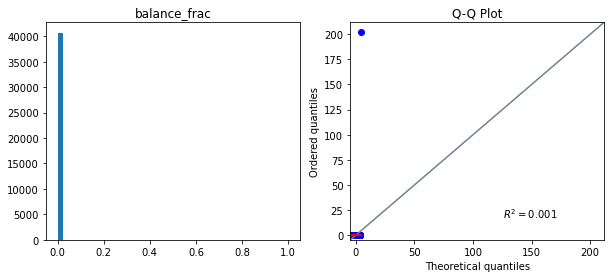

                     W  pval  normal
balance_sqrt  0.859064   0.0   False


C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


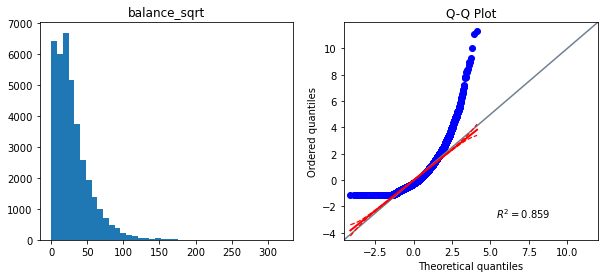

                            W  pval  normal
balance_frac_logmax  0.726449   0.0   False


C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


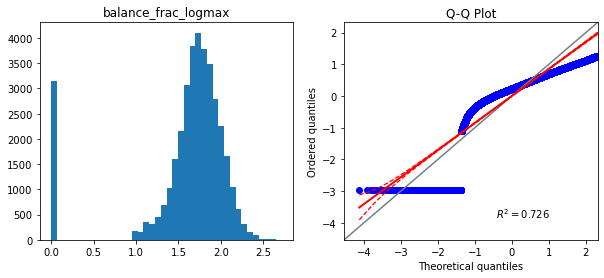

                       W  pval  normal
balance_boxcox  0.666122   0.0   False


C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


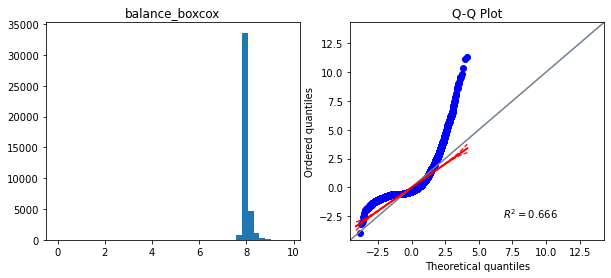

In [38]:
plot_distribution_transform(df, 'balance')

Podemos usar um modelo simples, como árvore de decisão, para avaliar quais transformações eliminaremos

Antes disso, eliminarei as transformações que geraram valores nulos

In [39]:
cols = [i for i in df.columns if 'balance' in i]
cols

['balance',
 'balance_log',
 'balance_frac',
 'balance_sqrt',
 'balance_frac_logmax',
 'balance_boxcox']

In [40]:
df[cols].isnull().sum()

balance                   0
balance_log               0
balance_frac              0
balance_sqrt           3391
balance_frac_logmax    3391
balance_boxcox            0
dtype: int64

In [41]:
df = drop_cols(df, ['balance_sqrt', 'balance_frac_logmax'])

In [42]:
cols = [i for i in df.columns if 'balance' in i]
cols

['balance', 'balance_log', 'balance_frac', 'balance_boxcox']

A transformação boxcox parece aumentar a discriminação, portanto eliminarei as demais

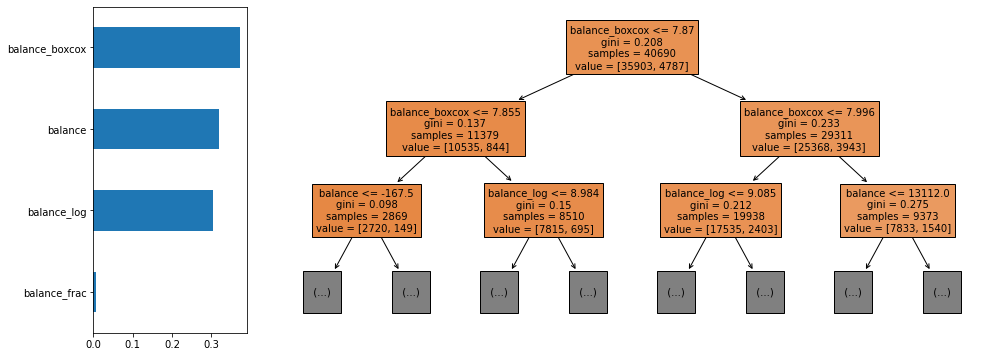

In [43]:
decision_tree_summary(df, cols)

In [48]:
cols.remove('balance_boxcox')

In [49]:
df = drop_cols(df, cols)

### 7) contact

O tipo de contato de comunicação não tem relacionamento com a target a um grau de confiança de 95%

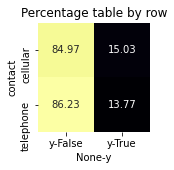

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    2.9680
1                    p-value =    0.0849
2               Cramer's phi =    0.0101
Dependency of variables very weak


In [50]:
chisquare(df, 'contact', figsize=(2, 2), prop='row')

Já a ausência desse canal parece ter um forte relacionamento

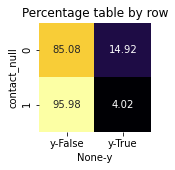

                Chi-square test   results
0  Pearson Chi-square ( 1.0) =   957.3652
1                    p-value =     0.0000
2               Cramer's phi =     0.1534
Dependency of variables is strong


In [51]:
chisquare(missing_flag(df, 'contact'), 'contact_null', figsize=(2, 2), prop='row')

Dessa forma, criarei uma coluna com flag de contato

In [52]:
df = missing_flag(df, 'contact')

In [53]:
df = drop_cols(df, 'contact')

### 8) day and month

In [54]:
# transformando o mês em formato datetime
df['month'] = pd.to_datetime(df['month'], format='%b').dt.month

Observando a contagem de registros de cada mês e dia juntos, observamos uma concentração entre maio e agosto

Podemos questionar a área de negócio se existe uma sazonalidade na campanha que pode interferir no resultado

Por não saber o ano que foi coletado, não consegui criar variáveis como dia da semana para avaliar se ajuda a identificar as targets

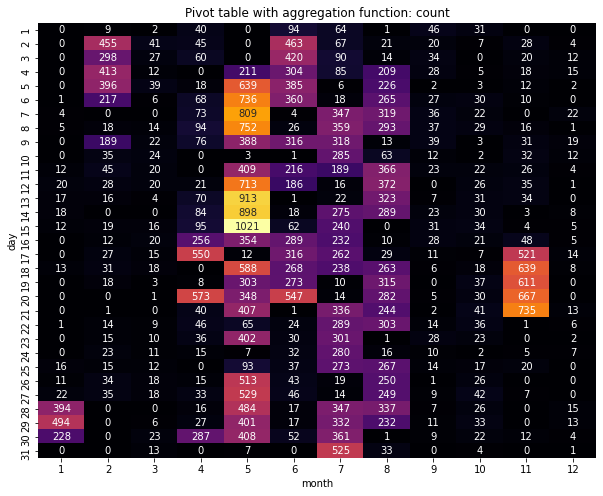

In [55]:
plot_pivot_table(df, 'day', 'month')

Podemos observar que apesar de con média de target, observamos que em maio há uma grande concentração de usuários que não se inscreveram

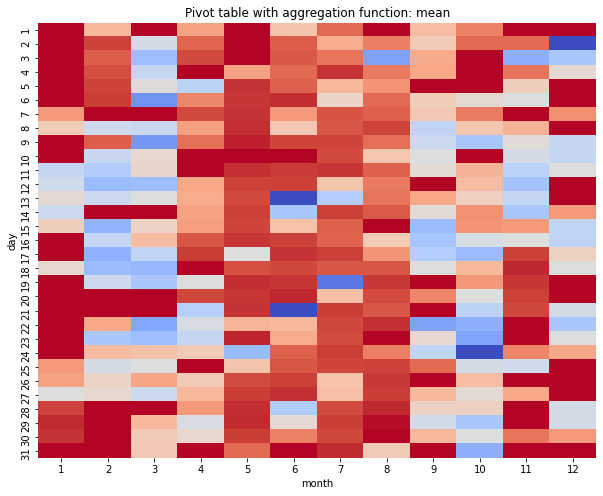

In [56]:
plot_pivot_table(df, 'day', 'month', aggfunc='mean',
                 annot=False, cmap='coolwarm_r')

Avaliando dia e mês individualmente, ambos parecem ajudar a discriminar a target

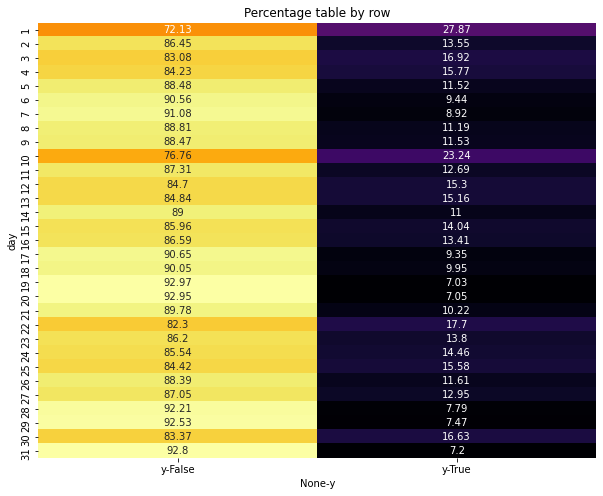

                 Chi-square test   results
0  Pearson Chi-square ( 30.0) =   498.3910
1                     p-value =     0.0000
2                  Cramer's V =     0.1107
Dependency of variables is moderate


In [57]:
chisquare(df, 'day', figsize=(10, 8), prop='row')

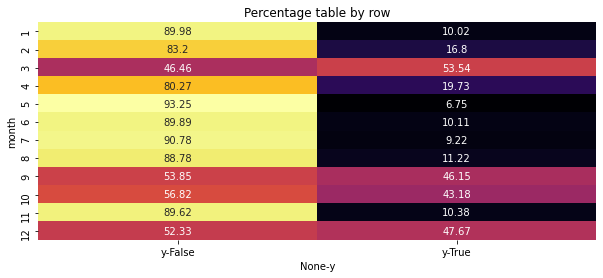

                 Chi-square test    results
0  Pearson Chi-square ( 11.0) =   2755.7764
1                     p-value =      0.0000
2                  Cramer's V =      0.2602
Dependency of variables is very strong


In [58]:
chisquare(df, 'month', prop='row')

### 9) duration

Assim como balanço, duração tem distribuição assimétrica e realizarei os mesmos passos para criar e avaliar trasnformações

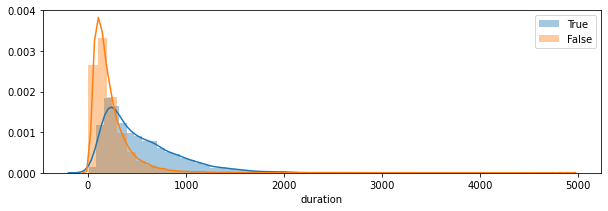

In [59]:
plot_distributions(df, 'duration')

In [60]:
difference_summary(df, 'duration')

Mann-Whitney U Test
Statistics: 33107828.0 | p-value: 0.0
Different distribution (reject H0)


In [61]:
df = transform_distribution(df, 'duration')

Min value: 0


C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


                 W  pval  normal
duration  0.727278   0.0   False


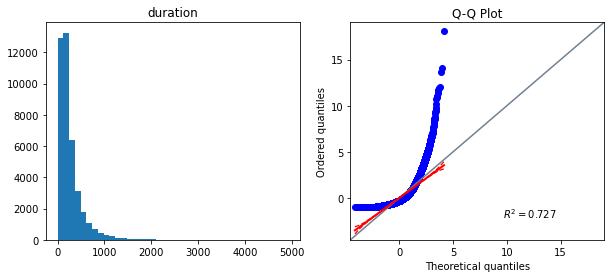

                     W  pval  normal
duration_log  0.985039   0.0   False


C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


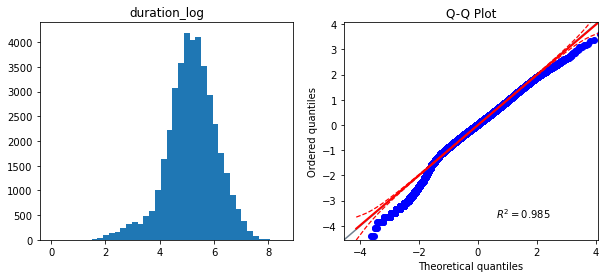

                      W  pval  normal
duration_frac  0.349551   0.0   False


C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


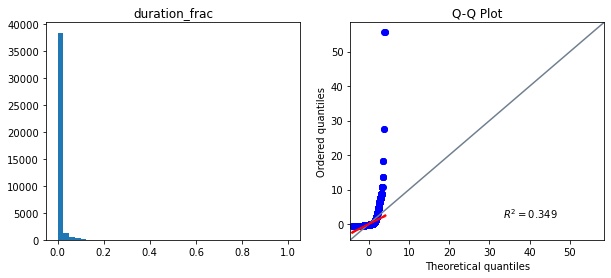

                    W  pval  normal
duration_sqrt  0.9349   0.0   False


C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


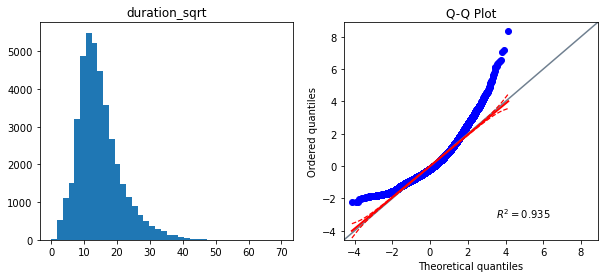

                             W          pval  normal
duration_frac_logmax  0.992917  3.909250e-39   False


C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


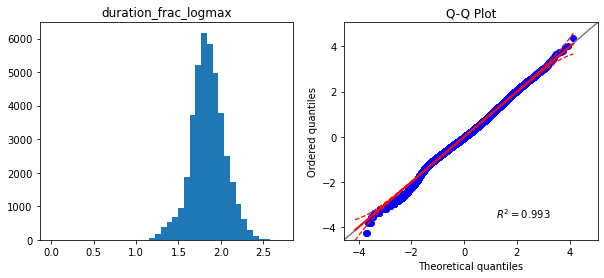

                        W          pval  normal
duration_boxcox  0.995717  1.226824e-31   False


C:\Users\milto\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


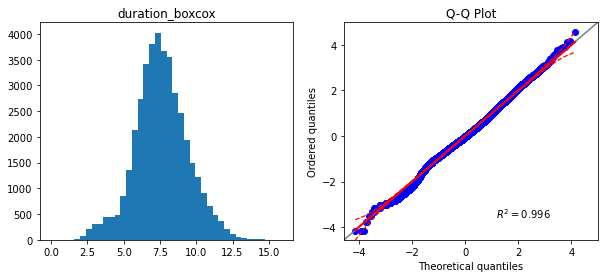

In [62]:
plot_distribution_transform(df, 'duration')

In [63]:
cols = [i for i in df.columns if 'duration' in i]
cols

['duration',
 'duration_log',
 'duration_frac',
 'duration_sqrt',
 'duration_frac_logmax',
 'duration_boxcox']

De acordo com a árvore de decisão, a duração crua mais auxiliou no incremento de discriminação

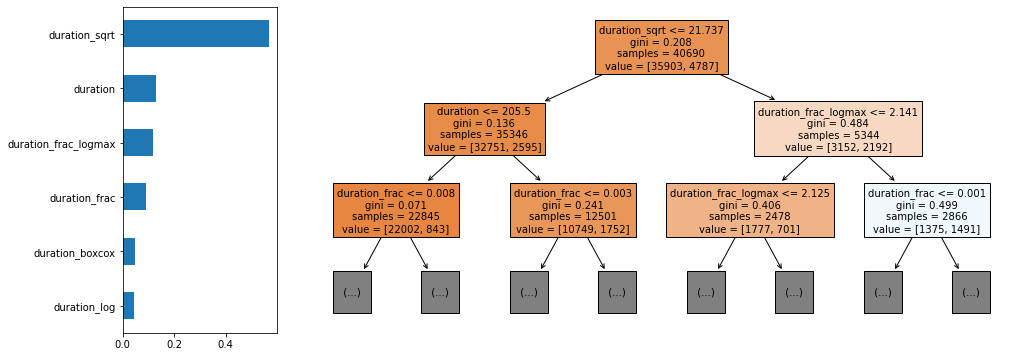

In [64]:
decision_tree_summary(df, cols)

Pela regressão logística, todas as variáveis são significativos, de acordo com o p-valor

In [65]:
logistic_regression_summary(df, cols)

C:\Users\milto\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\milto\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:893: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\milto\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\milto\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\milto\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:893: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                40690
Model:                            GLM   Df Residuals:                    40683
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 21 Jun 2020   Deviance:                          nan
Time:                        15:42:26   Pearson chi2:                 2.16e+19
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3.145e+16 

C:\Users\milto\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:946: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\milto\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:946: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +


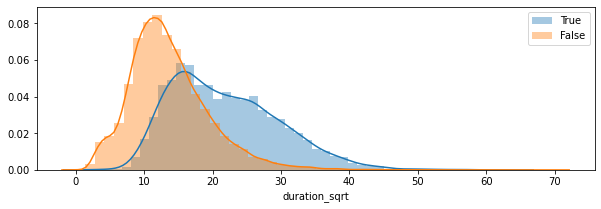

In [67]:
plot_distributions(df, 'duration_sqrt')

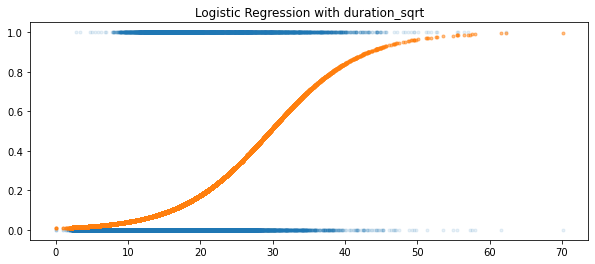

In [66]:
plot_logistic_regression(df, 'duration_sqrt')

A melhor transformação foi a raiz quadrada, então permanecerei com ela

In [68]:
cols.remove('duration_sqrt')
cols

['duration',
 'duration_log',
 'duration_frac',
 'duration_frac_logmax',
 'duration_boxcox']

In [69]:
df = drop_cols(df, cols)

### 10) campaign

O número de contatos realizados durante a campanha também tem distribuição assimétrica

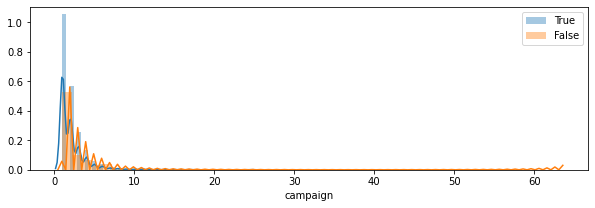

In [70]:
plot_distributions(df, 'campaign')

In [71]:
difference_summary(df, 'campaign')

Mann-Whitney U Test
Statistics: 73665992.0 | p-value: 1.9158897759006078e-63
Different distribution (reject H0)


Sendo que a partir de 17 os dados começam a ficar muito granularizados, dessa forma agregarei todos valores acima de 17

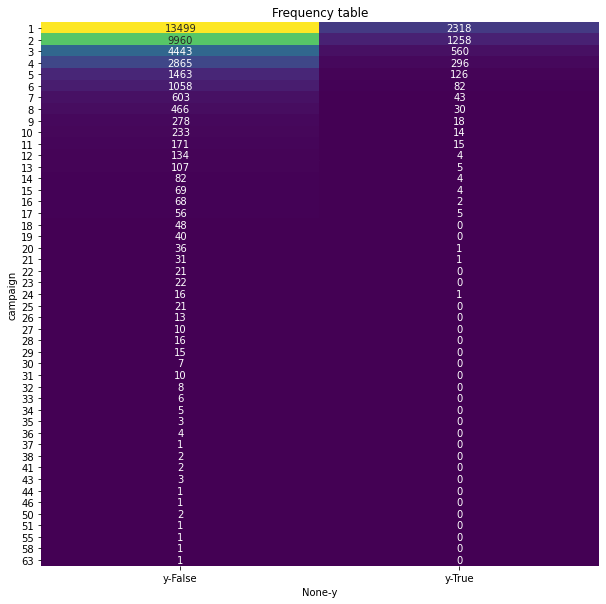

                 Chi-square test   results
0  Pearson Chi-square ( 46.0) =   317.9260
1                     p-value =     0.0000
2                  Cramer's V =     0.0884
Dependency of variables is weak


In [72]:
chisquare(df, 'campaign', figsize=(10, 10))

In [73]:
df.loc[df['campaign']>17,'campaign'] = 18

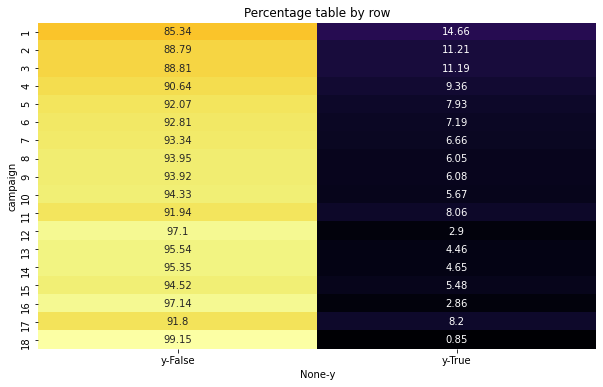

                 Chi-square test   results
0  Pearson Chi-square ( 17.0) =   317.0450
1                     p-value =     0.0000
2                  Cramer's V =     0.0883
Dependency of variables is weak


In [74]:
chisquare(df, 'campaign', figsize=(10, 6), prop='row')

### 11) pdays and previous

Como visto anteriormente, `pdays` e `previous` têm alta correlação monotônica e valores nulos

Criarei uma flag caso essas variáveis tenham valor `-1` e `0`, respectivamente, significando que são valores nulos

In [75]:
df = feature_flag(df, 'pdays', -1)
df = feature_flag(df, 'previous', 0)

Curiosamente os valores nulos de ambas variáveis são nos mesmos consumidores, e por isso que tinham alta correlação de spearman

In [76]:
pd.crosstab(df['pdays_flag'], df['previous_flag'])

previous_flag,False,True
pdays_flag,,
False,33279,0
True,0,7411


Observamos que a flag de missing traz ganho expressivo na discriminação da target

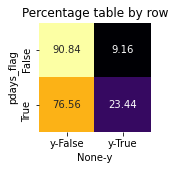

                Chi-square test    results
0  Pearson Chi-square ( 1.0) =   1189.5506
1                    p-value =      0.0000
2               Cramer's phi =      0.1710
Dependency of variables is strong


In [77]:
chisquare(df, 'pdays_flag', figsize=(2, 2), prop='row')

Por ora, eliminarei os valores nulos e examinarei qual das duas variáveis mais auxilia a identificar a target

In [78]:
a = deepcopy(df[df['pdays_flag']==1])

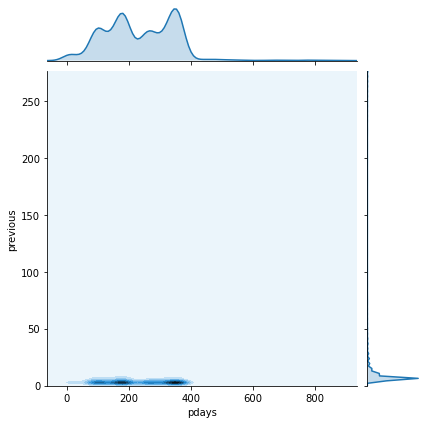

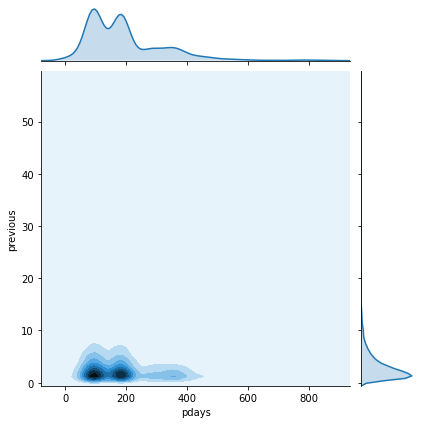

In [79]:
sns.jointplot(data=a[a['y'] == 0], x='pdays', y='previous', kind='kde')
plt.show()
sns.jointplot(data=a[a['y'] == 1], x='pdays', y='previous', kind='kde')
plt.show()

Aplicando as transformações nas variáveis e examinado pela árvore de decisão, percebemos que a transformação `frac_logmax` em `pdays` e `boxcox` em `previous` que mais tiveram ganhos, então substituirei elas no dataset original

In [80]:
a = transform_distribution(a, 'pdays')
a = transform_distribution(a, 'previous')

Min value: 1
Min value: 1


In [81]:
cols_pdays = [i for i in a.columns if 'pdays' in i]
cols_previous = [i for i in a.columns if 'previous' in i]
cols = cols_pdays + cols_previous

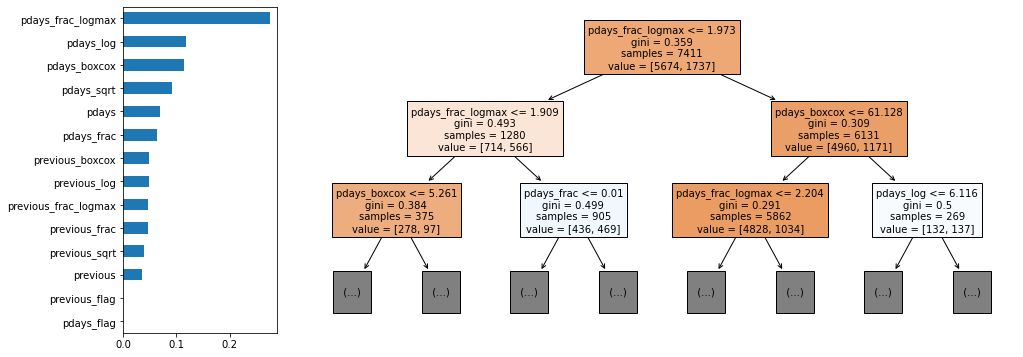

In [82]:
decision_tree_summary(a, cols)

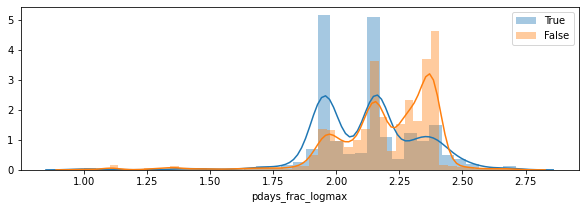

In [83]:
plot_distributions(a, 'pdays_frac_logmax')

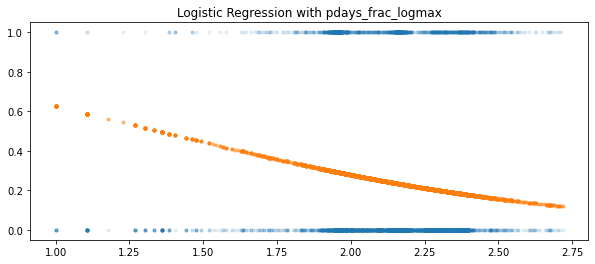

In [84]:
plot_logistic_regression(a, 'pdays_frac_logmax')

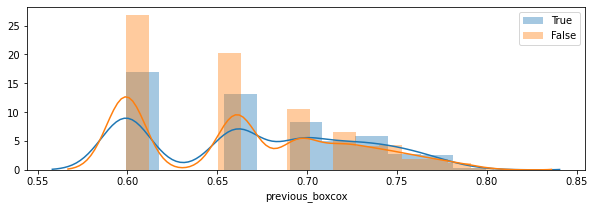

In [86]:
plot_distributions(a, 'previous_boxcox')

In [89]:
df = drop_cols(df, 'previous_flag')

In [90]:
df.loc[df['pdays_flag']==1, 'pdays'] = a['pdays_frac_logmax']
df.rename(columns={'pdays': 'pdays_frac_logmax'}, inplace=True)

In [91]:
df.loc[df['pdays_flag']==1, 'previous'] = a['pdays_boxcox']
df.rename(columns={'previous': 'pdays_boxcox'}, inplace=True)

### 15) poutcome

Por fim, o resultado da campanha anterior aparenta ser significativo na discriminação da target

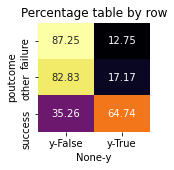

                Chi-square test    results
0  Pearson Chi-square ( 2.0) =   1627.8389
1                    p-value =      0.0000
2                 Cramer's V =      0.4688
Dependency of variables is very strong


In [92]:
chisquare(df, 'poutcome', figsize=(2, 2), prop='row')

In [93]:
df = missing_flag(df, 'poutcome', 'missing')

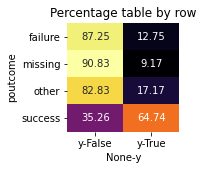

                Chi-square test    results
0  Pearson Chi-square ( 3.0) =   3999.3883
1                    p-value =      0.0000
2                 Cramer's V =      0.3135
Dependency of variables is very strong


In [94]:
chisquare(df, 'poutcome', figsize=(2, 2), prop='row')

## 4) Redução de dimensionalidade

Antes de prosseguir com a modelagem, utilizarei PCA como técnica de redução de dimensionalidade para avaliar quais variáveis tem maior variância explicativa

In [136]:
x = deepcopy(drop_cols(df, 'y'))

x = pd.get_dummies(x, drop_first=True)
x = x.select_dtypes(exclude='float').astype(int)
y = deepcopy(df['y'])

In [111]:
pca = PCA(random_state=42).fit(x)

A variância explicativa está acumulada em poucas variáveis

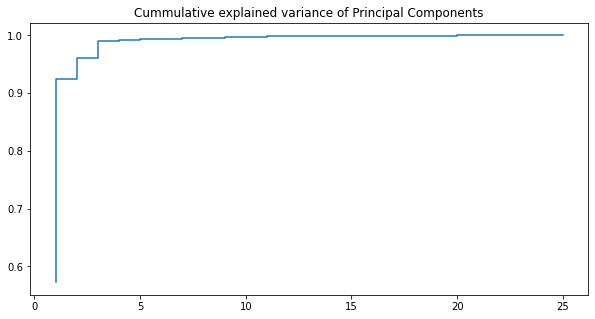

In [128]:
cum_variances_explained = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(10,5))
plt.title('Cummulative explained variance of Principal Components')
plt.step(list(range(1,len(cum_variances_explained)+1)),cum_variances_explained)
plt.show()

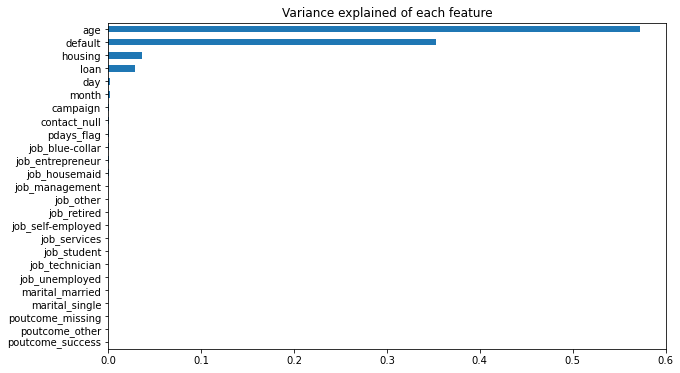

In [130]:
var_exp = pd.Series(pca.explained_variance_ratio_, index=x.columns).sort_values()
var_exp.plot.barh(figsize=(10, 6),title='Variance explained of each feature');

Dessa forma, podemos plotar as 3 variáveis com maiores variâncias e observar se elas discriminam a target

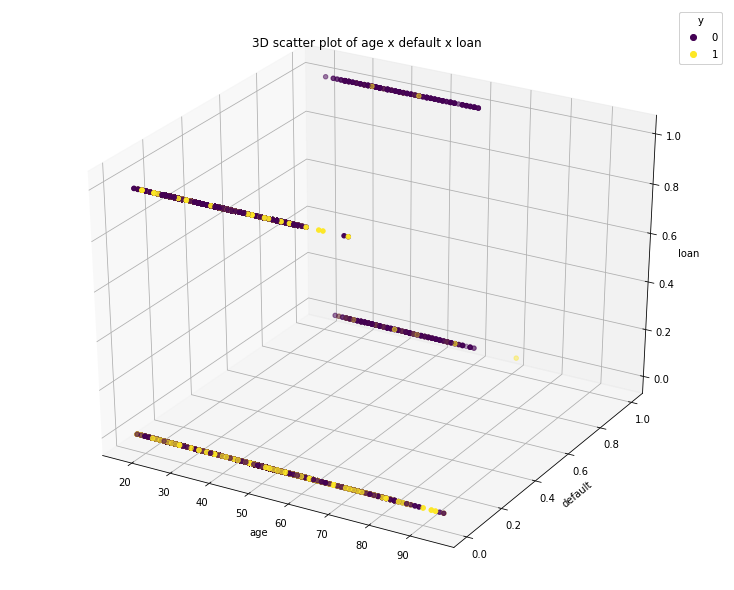

In [328]:
plot_3d_scatterplot(df, 'age', 'default', 'loan', 'y')

## 5) Modelagem

### 1) Modelo baseline

Como os dados são desbalanceados, utilizarei o `RandomUnderSampler` para balancear as targets

Farei a modelagem inicial com o automl `pycaret` para ter um baseline e verificar qual melhor modelo para meu dataset

In [185]:
df_pycaret = deepcopy(df)
col_bool = df_pycaret.select_dtypes('bool').columns
df_pycaret[col_bool] = df_pycaret[col_bool].astype('uint8')

In [186]:
sampler = RandomUnderSampler()

In [189]:
df_pycaret = sampling(df_pycaret)

Before sampling
Values for each target:  {0: 35903, 1: 4787}
Percentage of each target:  {0: 0.88, 1: 0.12} 


After sampling
Values for each target:  {1: 4787, 0: 4787}
Percentage of each target:  {1: 0.5, 0: 0.5}


In [190]:
clf_setup = classification.setup(df_pycaret, 'y', categorical_features=['day'],
                                 numeric_features=['campaign', 'contact_null'])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,8201
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(9574, 18)"
4,Missing Values,False
5,Numeric Features,12
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Pelo visto, `catboost` foi o vencedor em todas as métricas, portanto utilizarei ele para tunar hiperparâmetros e obter o melhor modelo

In [191]:
classification.compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.866900,0.932900,0.890400,0.850800,0.869900,0.733800
1,Light Gradient Boosting Machine,0.864400,0.928000,0.885700,0.849700,0.867200,0.728700
2,Extreme Gradient Boosting,0.852400,0.924000,0.872200,0.839400,0.855300,0.704800
3,Gradient Boosting Classifier,0.851500,0.924000,0.873400,0.837300,0.854700,0.703000
4,Extra Trees Classifier,0.848700,0.917900,0.853100,0.845800,0.849200,0.697400
5,Random Forest Classifier,0.843000,0.909100,0.838800,0.846100,0.842400,0.686000
6,Logistic Regression,0.840300,0.915800,0.843000,0.839100,0.840700,0.680700
7,Ada Boost Classifier,0.840800,0.913400,0.833100,0.846800,0.839600,0.681500
8,Linear Discriminant Analysis,0.839300,0.916800,0.834000,0.843500,0.838400,0.678600
9,Ridge Classifier,0.839000,0.000000,0.833700,0.843200,0.838000,0.678000


### 2) Modelo otimizado

Realizarei o tuning de hiperparâmetros com gridsearch e validação cruzada com 5 pastas estratificadas para garantir que cada pasta receba a mesma proporção de target

O `catboost` permite receber variáveis categóricas diretamente no modelo, não necessitando de pré-tratamento 

Além disso, o parâmetro `scale_pos_weight` informa a proporção de cada classe para o `catboost`, não necessitando de aplicar técnicas de sampling para balancear a carga

In [199]:
cat_features = ['job', 'marital', 'day', 'month', 'poutcome'] # selecting categorical features
skf = StratifiedKFold(5, random_state=42) # assigning stratified k fold for each fold of cross-validation
scale_pos_weight = scale_pos_weight[0] / scale_pos_weight[1] # balancing weights of targets

In [204]:
x_train, x_test, y_train, y_test = train_test(df)

In [263]:
cb = CatBoostClassifier(iterations=50,
                        learning_rate=0.1,
                        scale_pos_weight=scale_pos_weight,
                        cat_features=cat_features)

In [264]:
grid = {'learning_rate': [0.1, 0.2],
        'depth': [7, 8, 9, 10],
        'l2_leaf_reg': [8, 9, 10]}

In [265]:
grid_search_result = cb.grid_search(grid, x_train, y_train, cv=skf, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Os melhores parâmetros são informados abaixo e aplicados na sequência para obter o modelo otimizado

In [266]:
grid_search_result['params']

{'depth': 7, 'l2_leaf_reg': 10, 'learning_rate': 0.2}

In [268]:
cb = CatBoostClassifier(iterations=50,
                        learning_rate=0.2,
                        depth=7,
                        l2_leaf_reg=10,
                        scale_pos_weight=scale_pos_weight,
                        cat_features=cat_features,
                        custom_loss=['AUC', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [269]:
cb.fit(x_train, y_train,
       eval_set=(x_test, y_test),
       verbose=False,
       cat_features=cat_features, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## 6) Resultados

As métricas e matriz de confusão do melhor modelo na base de teste são informadas abaixo

In [309]:
y_pred = cb.predict(x_test, prediction_type='Probability')[:,1].round()

In [310]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.83      0.90     10771
        True       0.41      0.86      0.56      1436

    accuracy                           0.84     12207
   macro avg       0.69      0.85      0.73     12207
weighted avg       0.91      0.84      0.86     12207



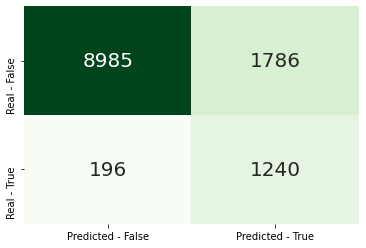

In [308]:
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Greens',
            cbar=False, annot=True, fmt='g', annot_kws={"size": 20},
            xticklabels=['Predicted - False', 'Predicted - True'],
            yticklabels=['Real - False', 'Real - True']);

A matriz de confusão pode ser interpretada da seguinte forma:
- **Verdadeiro Negativo (VN) = 8985:** Clientes que não se inscreveram para o produto e o modelo preveu que não se inscreveram
- **Falso Positivo (FP) = 1786:** Clientes que não se inscreveram para o produto e o modelo preveu que se inscreveram
- **Falso Negativo (FN) = 196:** Clientes que se inscreveram para o produto e o modelo preveu que não se inscreveram
- **Verdadeiro Positivo (VP) = 1240:** Clientes que se inscreveram para o produto e o modelo que se inscreveram

Em termos de negócio, podemos interpretar os valores como:
- **VN:** Clientes que não são propensos a se inscreverem, então não vale a pena investir em ações de marketing para incentivá-los a se inscreverem
- **FP:** Clientes que o modelo identificou propensão de se inscreverem, então podemos tentar atuar com incentivos para convertê-los
- **FN:** Clientes que o modelo não identificou como propensos a se inscreverem, mas que já são inscritos
- **VP:** Clientes que o modelo identificou propensão de se inscreverem e de fato se inscreveram

## 7) Interpretabilidade do modelo

Abaixo podemos verificar quais as variáveis mais importantes que contribuíram para a discriminação da target e a visualização 3D das 3 variáveis mais importantes para cada target

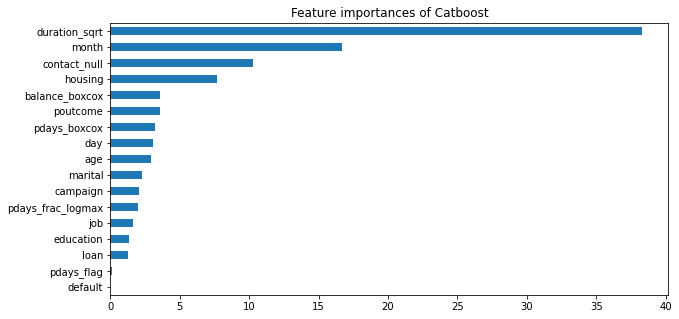

In [318]:
pd.Series(cb.get_feature_importance(), index=x_train.columns).sort_values().plot(kind='barh', figsize=(10, 5),
                                                                                 title='Feature importances of Catboost');

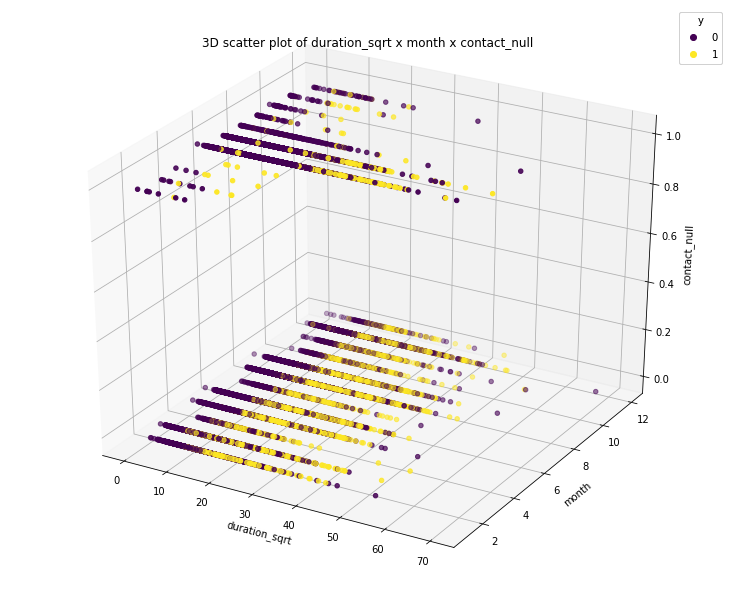

In [329]:
plot_3d_scatterplot(df, 'duration_sqrt', 'month', 'contact_null', 'y')